# Projeto Final Paradigmas de ML

## 1.0. Introdução

### 1.1. Integrante
- LUIS HENRIQUE LIMA BRANDAO - 20180116645


### 1.2. Problema

Prever a receita total de um turno baseado nos dias anteriores em um posto de gasolina

### 1.3. Objetivo

Utilizar um modelo de regrassão linear para realizar tais previsões

### 1.4. WorkFlow

Lembrete do WorkFlow:

![workflow](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmiro.medium.com%2Fmax%2F1400%2F1*gFYWIpNETvxjYMKBXTh0Qw.jpeg&f=1&nofb=1&ipt=72520dd51bcb65285ed8b7e1058affaf3add889b0b74cdec2a4070cbc93b59ed)

## 2.0 Setup inicial

### 2.1. Acesso ao Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.2. Instalação e Importação de Bibliotecas

In [ ]:
!pip install ydata_profiling > /dev/null

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ydata_profiling
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### 2.3. Configuração de Bibliotecas

In [ ]:
pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 900)

## 3.0. Get Data

### 3.1. Leitura do conjunto de dados original

In [ ]:
df_original = pd.read_csv(
    "drive/My Drive/ufpb/paradigmas-de-aprendizagem-de-maquina/projeto-final/VENDAS_ITENS_VENDAS_PRESTAÇÃO.csv",
    sep=";",
    low_memory=False,
    encoding="utf-8-sig",
)

# colocando a coluna alvo no final do dataframe pq eu (cirilo) tenho toc

col_vendas = df_original.pop('TOTAL_VENDAS')
df_original['TOTAL_VENDAS'] = col_vendas

In [ ]:
df_original.head()

,SEQ_CAIXA,SEQUENCIAL,DATA_EMISSAO,HORA_EMISSAO,COD_OPERADOR,COD_PRODUTO,QUANTIDADE,PRECO_CONTRATO,CUSTO,TURNO,TOTAL_VENDAS
0,2622,1,2024-03-01,60751,39,101001,5.031,5.19,4.807270,1,16475.52
1,2622,1,2024-03-01,60751,39,101001,5.031,5.19,4.807270,2,10524.29
2,2622,1,2024-03-01,60751,39,78919662037405,4.000,2.50,1.916111,1,16475.52
3,2622,1,2024-03-01,60751,39,78919662037405,4.000,2.50,1.916111,2,10524.29
4,2622,1,2024-03-01,60751,39,101001,2.514,5.57,5.010180,1,16475.52


In [ ]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6672321 entries, 0 to 6672320
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   SEQ_CAIXA       int64  
 1   SEQUENCIAL      int64  
 2   DATA_EMISSAO    object 
 3   HORA_EMISSAO    int64  
 4   COD_OPERADOR    int64  
 5   COD_PRODUTO     int64  
 6   QUANTIDADE      float64
 7   PRECO_CONTRATO  float64
 8   CUSTO           float64
 9   TURNO           int64  
 10  TOTAL_VENDAS    float64
dtypes: float64(4), int64(6), object(1)
memory usage: 560.0+ MB


### 3.2. Descrição do conjunto de dados Original

- **SEQ_CAIXA** Código identificador do caixa (terminal) onde a venda foi registrada. Permite distinguir diferentes pontos de atendimento.

- **SEQUENCIAL** Número sequencial da venda dentro daquele caixa. Junto com SEQ_CAIXA forma a chave única de cada transação.

- **DATA_EMISSAO** Data em que o caixa foi encerrado ou a venda registrada (formato YYYY-MM-DD). Usada para análise de sazonalidade e corte temporal.

- **HORA_EMISSAO** Hora em que o caixa foi encerrado ou a venda registrada (formato HH:MM:SS ou numérico convertido para esse formato). Importante para identificar picos de movimento por turno.

- **COD_OPERADOR** Código do operador (frentista) responsável pelo caixa naquele turno. Permite capturar diferenças de desempenho individuais.

- **COD_PRODUTO** Código do produto vendido (combustível ou outro item). Usado para segmentar receitas por tipo de produto.

- **QUANTIDADE** Quantidade de unidades vendidas na transação (litros de combustível ou unidades de produto).

- **PRECO_CONTRATO** Preço unitário aplicado na venda (valor cobrado por litro ou por unidade).

- **CUSTO** Custo unitário do produto para a empresa (valor pago ao fornecedor).

- **TOTAL_VENDAS** Valor total de vendas registrado no encerramento do caixa naquele turno—soma de todas as transações. É a variável-alvo do modelo.

- **TURNO** Identificador do turno de operação (por exemplo, 1=manhã, 2=tarde). Usado para agrupar vendas e modelar padrões intra-diários.

### 3.3. Criação de um novo conjunto de dados

Nessa sessão, como queremos prever a venda de um dia por turno baseado nos dias anteriores, é importante ter em mente que cada registro do conjunto original é atômico e representa apenas um reabastecimento.

Sendo assim, a minha idéia é criar uma nova tabela onde cada registro representa a venda total de um turno em um unico dia.

#### 3.3.1. Atributos de Feriado e Dia da Semana

Adicionamos atributos temporais que indicam qual o dia da semana, se é fim de semana e se é feriado, talvez isso influencie nos reabastecimentos.

In [ ]:
import holidays

df_aux = df_original.copy()
data_as_dt_aux = pd.to_datetime(df_aux['DATA_EMISSAO'])

br_holidays = holidays.Brazil(years=data_as_dt_aux.dt.year.unique())

# coluna feriado
df_aux['FERIADO'] = data_as_dt_aux.isin(br_holidays).astype(int)

# colunas temporais
df_aux['DIA_DA_SEMANA'] = data_as_dt_aux.dt.weekday
df_aux['MES'] = data_as_dt_aux.dt.month
df_aux['FIM_DE_SEMANA'] = (df_aux['DIA_DA_SEMANA'] >= 5).astype(int)
data_as_dt_aux = None

#df_aux['RECEITA_ITEM'] = df_aux['QUANTIDADE'] * df_aux['PRECO_CONTRATO']
#df_aux['MARGEM_ITEM'] = (df_aux['PRECO_CONTRATO'] - df_aux['CUSTO']) * df_aux['QUANTIDADE']

# liberar memoria
#data_as_dt_aux = None

<ipython-input-8-50af4d058fa8>:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_aux['FERIADO'] = data_as_dt_aux.isin(br_holidays).astype(int)


#### 3.3.2. Agrupamento por `DATA_EMISSAO` e `TURNO`

In [ ]:
df = df_aux.groupby(['DATA_EMISSAO', 'TURNO']).agg(
    TOTAL_VENDAS_TURNO=('TOTAL_VENDAS', 'first'),   # Soma das vendas do turno
    VOLUME_TURNO=('QUANTIDADE', 'sum'),             # total de litros/unidades
    PRECO_MEDIO=('PRECO_CONTRATO', 'mean'),         # preco medio no turno
    FERIADO=('FERIADO', 'first'),                   # indicador de feriado
    N_OPERADORES=('COD_OPERADOR', 'nunique'),       # num de operadores
    N_PRODUTOS=('COD_PRODUTO', 'nunique'),          # num de produtos
    N_TRANSACOES=('SEQUENCIAL','nunique'),
    DIA_DA_SEMANA=('DIA_DA_SEMANA', 'first'),
    MES=('MES', 'first'),
    EH_FIM_DE_SEMANA=('FIM_DE_SEMANA', 'first')
    #RECEITA_BRUTA_TURNO=('RECEITA_ITEM','sum'),
    #MARGEM_TURNO=('MARGEM_ITEM','sum'),
).reset_index()

#### 3.3.3. Atributos Seno e Cosseno Para Atributos Temporais Cíclicos

No site do `scikit-learn` há um artigo sobre engenharia de problemas de regressão com dados temporais, lá eles afirmam que é interessante para os modelos normalizar os atributos temporais cíclicos (que se repetem) com as funções seno e cosseno. Isso já normaliza os atributos.

In [ ]:
# dia da semana e mês
df['DIA_SIN'] = np.sin(2 * np.pi * (df['DIA_DA_SEMANA'] - 1) / 7)
df['DIA_COS'] = np.cos(2 * np.pi * (df['DIA_DA_SEMANA'] - 1) / 7)
df['MES_SIN'] = np.sin(2 * np.pi * (df['MES'] - 1) / 12)
df['MES_COS'] = np.cos(2 * np.pi * (df['MES'] - 1) / 12)

#### 3.3.4. Criação dos Atributos de Defasagens (LAGs) e Médias Móvies

In [ ]:
for lag in [1, 2, 7]:
    df[f'LAG_{lag}'] = df['TOTAL_VENDAS_TURNO'].shift(lag)
df['MA_3'] = df['TOTAL_VENDAS_TURNO'].rolling(3,  min_periods=1).mean()
df['MA_7'] = df['TOTAL_VENDAS_TURNO'].rolling(7,  min_periods=1).mean()

In [ ]:
df

,DATA_EMISSAO,TURNO,TOTAL_VENDAS_TURNO,VOLUME_TURNO,PRECO_MEDIO,FERIADO,N_OPERADORES,N_PRODUTOS,N_TRANSACOES,DIA_DA_SEMANA,MES,EH_FIM_DE_SEMANA,DIA_SIN,DIA_COS,MES_SIN,MES_COS,LAG_1,LAG_2,LAG_7,MA_3,MA_7
0,2024-03-01,1,16475.52,151711.958,5.601570,0,6,91,301,4,3,0,0.433884,-0.900969,0.866025,5.000000e-01,NaN,NaN,NaN,16475.520000,16475.520000
1,2024-03-01,2,10524.29,95398.414,5.704393,0,7,104,336,4,3,0,0.433884,-0.900969,0.866025,5.000000e-01,16475.52,NaN,NaN,13499.905000,13499.905000
2,2024-03-01,3,7893.87,11000.758,6.018483,0,1,46,94,4,3,0,0.433884,-0.900969,0.866025,5.000000e-01,10524.29,16475.52,NaN,11631.226667,11631.226667
3,2024-03-02,1,12442.86,151920.825,5.683616,0,6,99,274,5,3,1,-0.433884,-0.900969,0.866025,5.000000e-01,7893.87,10524.29,NaN,10287.006667,11834.135000
4,2024-03-02,2,4285.94,93517.055,5.609445,0,6,82,277,5,3,1,-0.433884,-0.900969,0.866025,5.000000e-01,12442.86,7893.87,NaN,8207.556667,10324.496000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,2025-04-15,1,9573.64,63566.888,5.729726,0,7,39,279,1,4,0,0.000000,1.000000,1.000000,6.123234e-17,3801.91,9522.92,17119.11,7632.823333,9713.661429
1004,2025-04-15,2,4243.97,41457.750,5.701049,0,5,17,229,1,4,0,0.000000,1.000000,1.000000,6.123234e-17,9573.64,3801.91,9662.40,5873.173333,8939.600000
1005,2025-04-16,1,13444.22,42609.771,5.775748,0,6,40,274,2,4,0,0.781831,0.623490,1.000000,6.123234e-17,4243.97,9573.64,13450.39,9087.276667,8938.718571
1006,2025-04-16,2,3756.41,25499.389,5.791754,0,5,10,275,2,4,0,0.781831,0.623490,1.000000,6.123234e-17,13444.22,4243.97,10075.51,7148.200000,8035.990000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DATA_EMISSAO        1008 non-null   object 
 1   TURNO               1008 non-null   int64  
 2   TOTAL_VENDAS_TURNO  1008 non-null   float64
 3   VOLUME_TURNO        1008 non-null   float64
 4   PRECO_MEDIO         1008 non-null   float64
 5   FERIADO             1008 non-null   int64  
 6   N_OPERADORES        1008 non-null   int64  
 7   N_PRODUTOS          1008 non-null   int64  
 8   N_TRANSACOES        1008 non-null   int64  
 9   DIA_DA_SEMANA       1008 non-null   int32  
 10  MES                 1008 non-null   int32  
 11  EH_FIM_DE_SEMANA    1008 non-null   int64  
 12  DIA_SIN             1008 non-null   float64
 13  DIA_COS             1008 non-null   float64
 14  MES_SIN             1008 non-null   float64
 15  MES_COS             1008 non-null   float64
 16  LAG_1 

In [ ]:
print(f"Conjunto Original: {df_original.shape}")
print(f"Conjunto Novo:     {df.shape}")

Conjunto Original: (6672321, 11)
Conjunto Novo:     (1008, 21)


### 3.4. Exploração de dados com `ydata_profiling`

In [ ]:
profile = ProfileReport(df)
profile.to_notebook_iframe()

## 4.0. Clean, Prepare & Manipulate Data

Guia para evitar o vazamento de dados (slides da professora):

1. **Normalização e Padronização:** Realizar a normalização ou padronização dos dados deve ser feito **após a divisão** dos conjuntos. Isso evita que informações do conjunto de teste influenciem o treinamento.

1. **Tratamento de Dados Ausentes:** Impute ou remova dados ausentes **antes da divisão**. Se você tratar dados ausentes após a divisão, pode inadvertidamente usar informações do conjunto de teste para influenciar o conjunto de treinamento.

1. **Codificação de Variáveis Categóricas:** A codificação deve ser realizada de forma que a variável categórica não revele informações do conjunto de teste ao conjunto de treinamento. Use técnicas como One-Hot Encoding **após a divisão**.

1. **Remoção de Outliers:** Identifique e remova outliers **antes da divisão** para garantir que o modelo não seja influenciado por dados extremos que podem não se repetir no conjunto de teste.

1. **Divisão Aleatória:** Realize a divisão de forma aleatória para garantir que ambos os conjuntos (treinamento e teste) sejam representativos da distribuição original dos dados.

1. **Validação Cruzada:** Utilize validação cruzada para avaliar o modelo de forma robusta, garantindo que a avaliação não se baseie em um único conjunto de teste.

1. **Separação de Dados Temporais:** Se os dados forem temporais, **mantenha a ordem temporal ao dividir os conjuntos**, evitando que informações futuras sejam usadas para prever o passado.

### 4.1. Remoção de registros faltantes



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DATA_EMISSAO        1008 non-null   object 
 1   TURNO               1008 non-null   int64  
 2   TOTAL_VENDAS_TURNO  1008 non-null   float64
 3   VOLUME_TURNO        1008 non-null   float64
 4   PRECO_MEDIO         1008 non-null   float64
 5   FERIADO             1008 non-null   int64  
 6   N_OPERADORES        1008 non-null   int64  
 7   N_PRODUTOS          1008 non-null   int64  
 8   N_TRANSACOES        1008 non-null   int64  
 9   DIA_DA_SEMANA       1008 non-null   int32  
 10  MES                 1008 non-null   int32  
 11  EH_FIM_DE_SEMANA    1008 non-null   int64  
 12  DIA_SIN             1008 non-null   float64
 13  DIA_COS             1008 non-null   float64
 14  MES_SIN             1008 non-null   float64
 15  MES_COS             1008 non-null   float64
 16  LAG_1 

In [ ]:
# Limpar NaNs gerados pelos lags/médias
df = df.dropna().reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DATA_EMISSAO        1001 non-null   object 
 1   TURNO               1001 non-null   int64  
 2   TOTAL_VENDAS_TURNO  1001 non-null   float64
 3   VOLUME_TURNO        1001 non-null   float64
 4   PRECO_MEDIO         1001 non-null   float64
 5   FERIADO             1001 non-null   int64  
 6   N_OPERADORES        1001 non-null   int64  
 7   N_PRODUTOS          1001 non-null   int64  
 8   N_TRANSACOES        1001 non-null   int64  
 9   DIA_DA_SEMANA       1001 non-null   int32  
 10  MES                 1001 non-null   int32  
 11  EH_FIM_DE_SEMANA    1001 non-null   int64  
 12  DIA_SIN             1001 non-null   float64
 13  DIA_COS             1001 non-null   float64
 14  MES_SIN             1001 non-null   float64
 15  MES_COS             1001 non-null   float64
 16  LAG_1 

### 4.2. Remoção de registros duplicados

In [ ]:
print(f"duplicados: {sum(df.duplicated())}")
print(f"shape: {df.shape}")

duplicados: 0
shape: (1001, 21)


### 4.3. Conversão para valores numéricos

In [ ]:
# DATA
import datetime as dt
df.DATA_EMISSAO = pd.to_datetime(df.DATA_EMISSAO)
df.DATA_EMISSAO = df.DATA_EMISSAO.map(dt.datetime.toordinal)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DATA_EMISSAO        1001 non-null   int64  
 1   TURNO               1001 non-null   int64  
 2   TOTAL_VENDAS_TURNO  1001 non-null   float64
 3   VOLUME_TURNO        1001 non-null   float64
 4   PRECO_MEDIO         1001 non-null   float64
 5   FERIADO             1001 non-null   int64  
 6   N_OPERADORES        1001 non-null   int64  
 7   N_PRODUTOS          1001 non-null   int64  
 8   N_TRANSACOES        1001 non-null   int64  
 9   DIA_DA_SEMANA       1001 non-null   int32  
 10  MES                 1001 non-null   int32  
 11  EH_FIM_DE_SEMANA    1001 non-null   int64  
 12  DIA_SIN             1001 non-null   float64
 13  DIA_COS             1001 non-null   float64
 14  MES_SIN             1001 non-null   float64
 15  MES_COS             1001 non-null   float64
 16  LAG_1 

In [ ]:
df.head()

,DATA_EMISSAO,TURNO,TOTAL_VENDAS_TURNO,VOLUME_TURNO,PRECO_MEDIO,FERIADO,N_OPERADORES,N_PRODUTOS,N_TRANSACOES,DIA_DA_SEMANA,MES,EH_FIM_DE_SEMANA,DIA_SIN,DIA_COS,MES_SIN,MES_COS,LAG_1,LAG_2,LAG_7,MA_3,MA_7
0,738948,2,7397.45,71754.360,5.619155,0,5,70,241,6,3,1,-0.974928,-0.222521,0.866025,0.5,8194.65,4422.04,16475.52,6671.380000,7880.157143
1,738948,3,6042.58,16171.100,5.521849,0,1,27,84,6,3,1,-0.974928,-0.222521,0.866025,0.5,7397.45,8194.65,10524.29,7211.560000,7239.912857
2,738949,1,16938.42,119913.218,5.675416,0,5,89,332,0,3,0,-0.781831,0.623490,0.866025,0.5,6042.58,7397.45,7893.87,10126.150000,8531.991429
3,738949,2,8395.95,115859.074,5.623815,0,7,90,325,0,3,0,-0.781831,0.623490,0.866025,0.5,16938.42,6042.58,12442.86,10458.983333,7953.861429
4,738950,1,11556.15,124909.485,6.125595,0,6,109,318,1,3,0,0.000000,1.000000,0.866025,0.5,8395.95,16938.42,4285.94,12296.840000,8992.462857


### 4.4. Tratamento de classes majoritárias

Tratar classes majoritárias para evitar o overfiting


### 4.4. Tratamento de Outliers

#### 4.4.1. Análise de Outliers

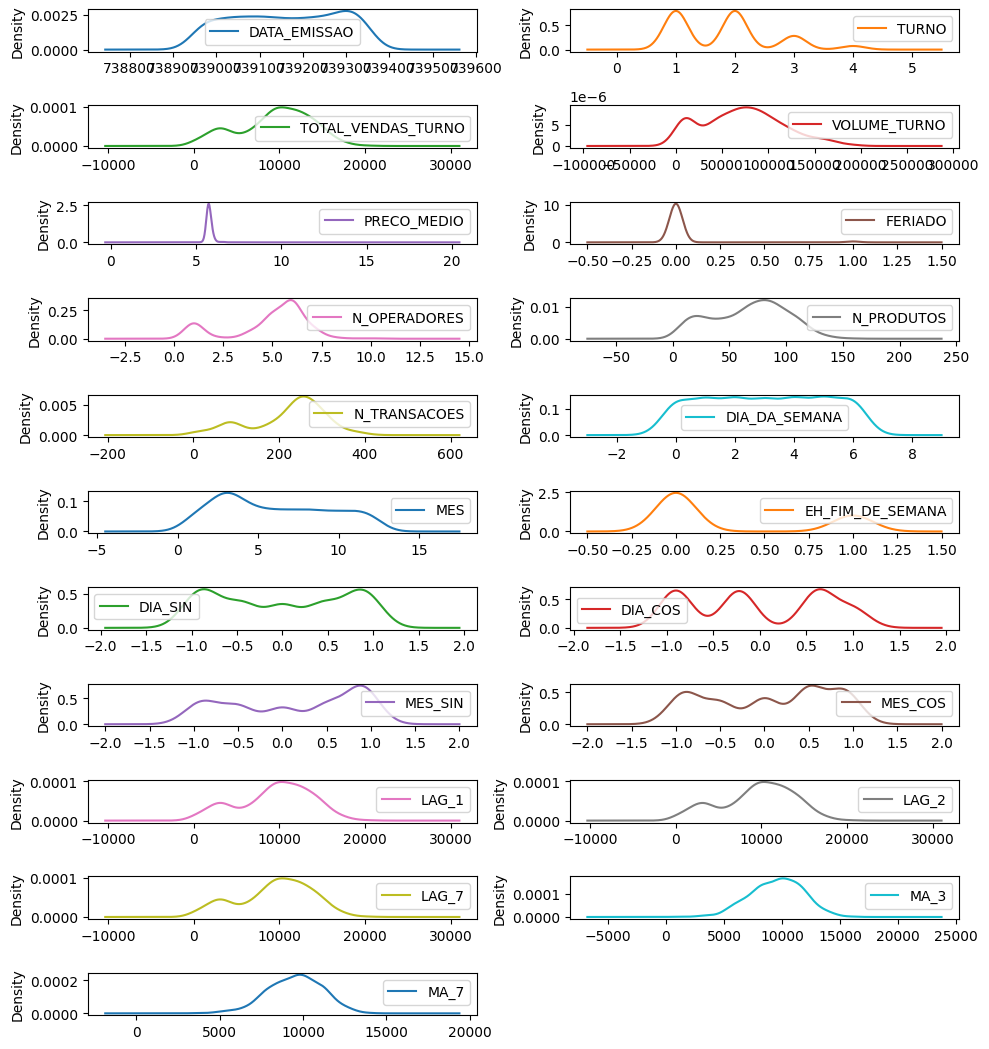

In [ ]:
df.plot(kind="density",
          subplots=True,
          sharex=False,
          layout=(df.shape[1],2),
          figsize=(10,20))
plt.tight_layout()
plt.show()

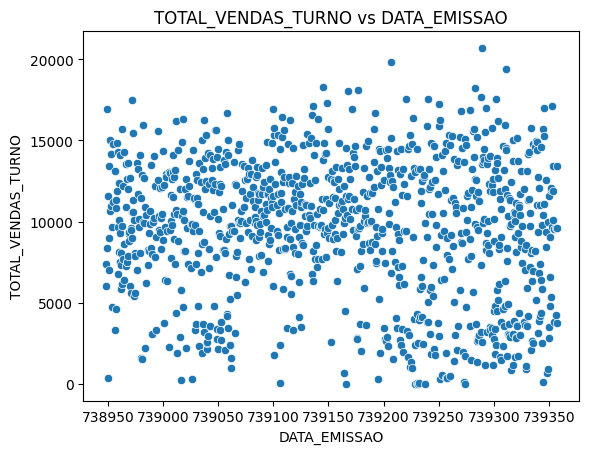

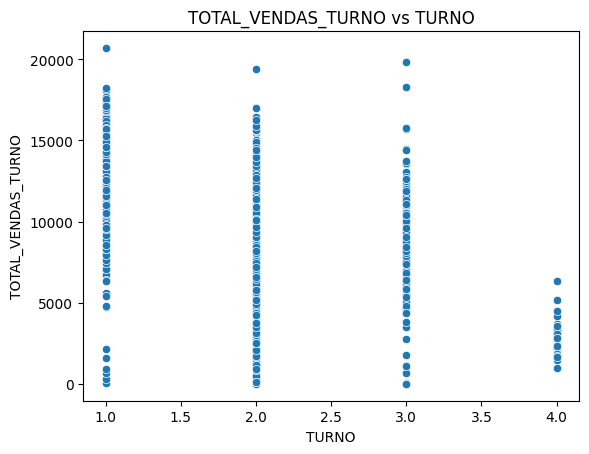

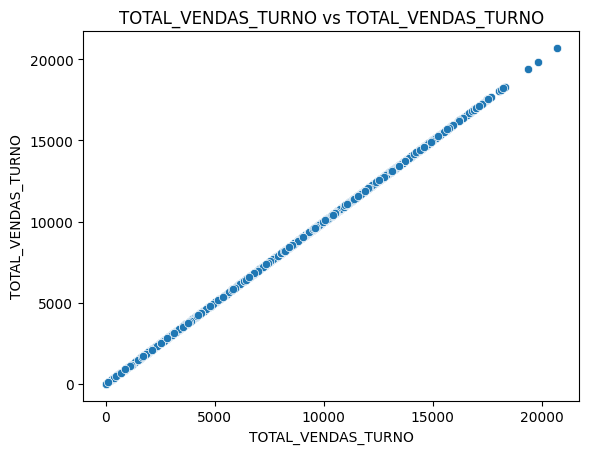

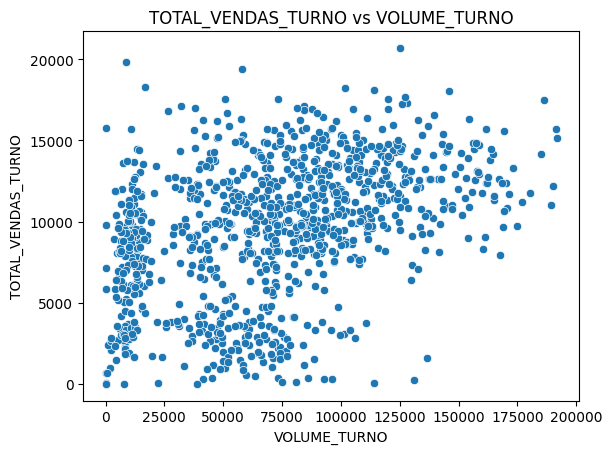

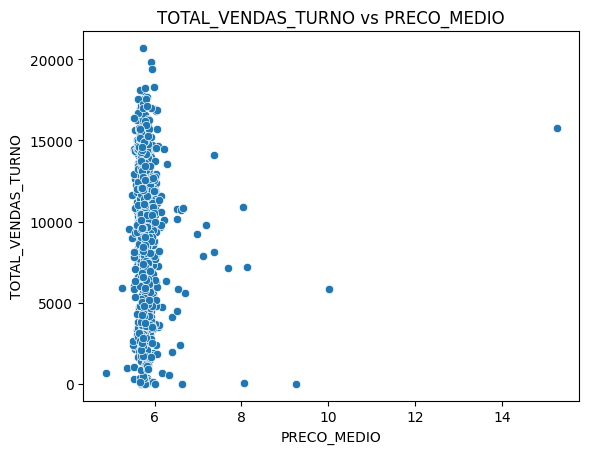

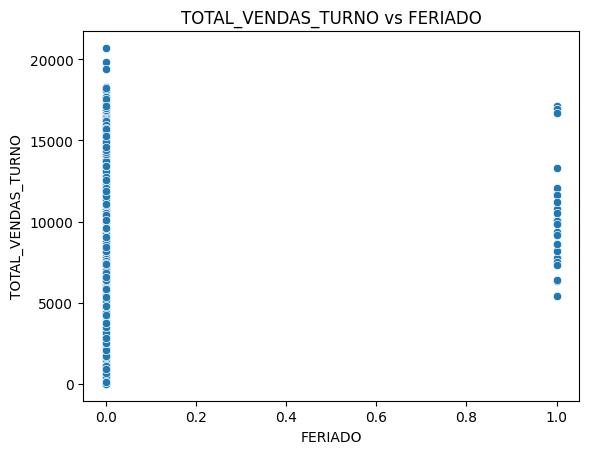

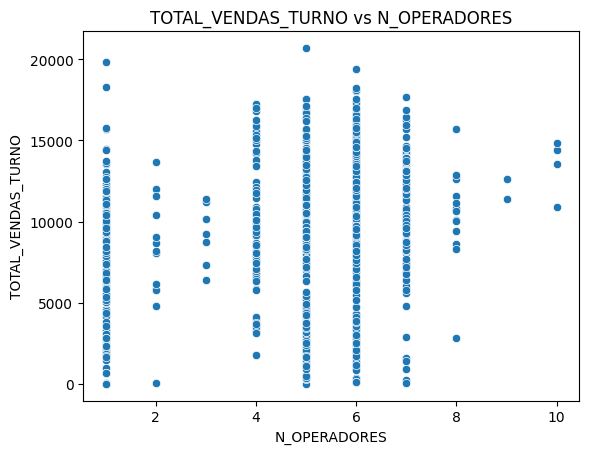

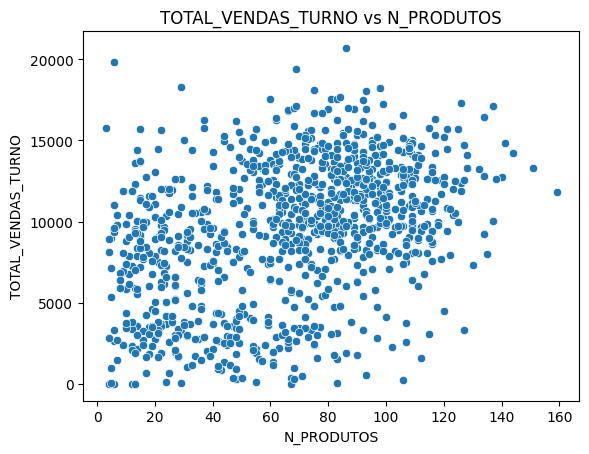

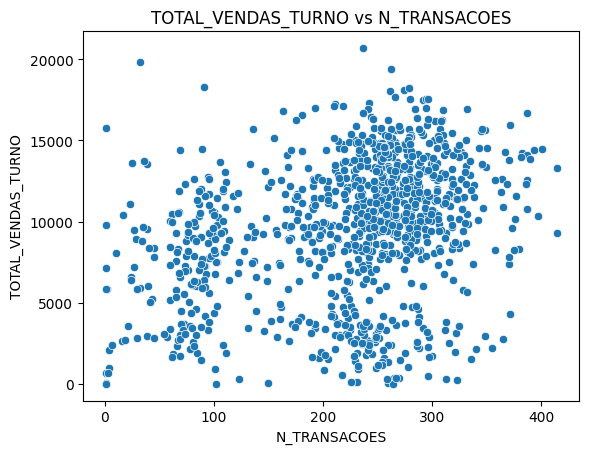

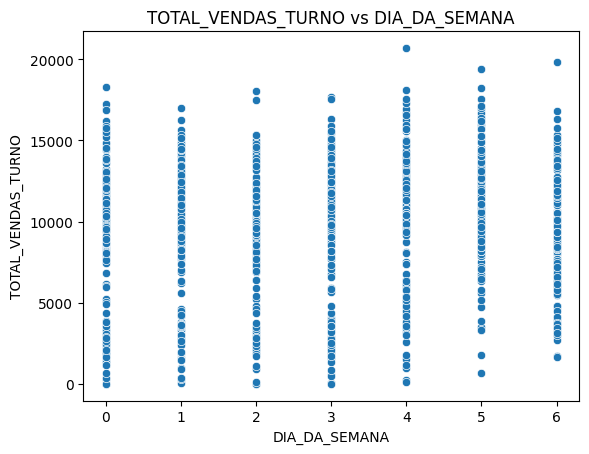

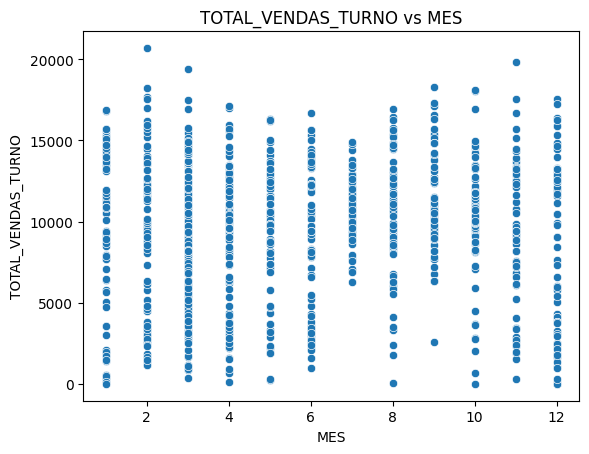

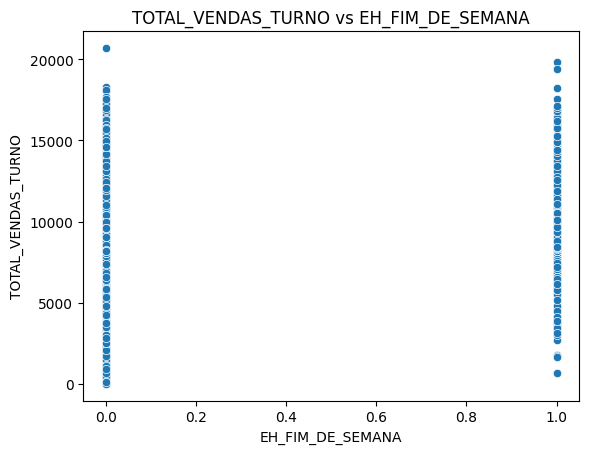

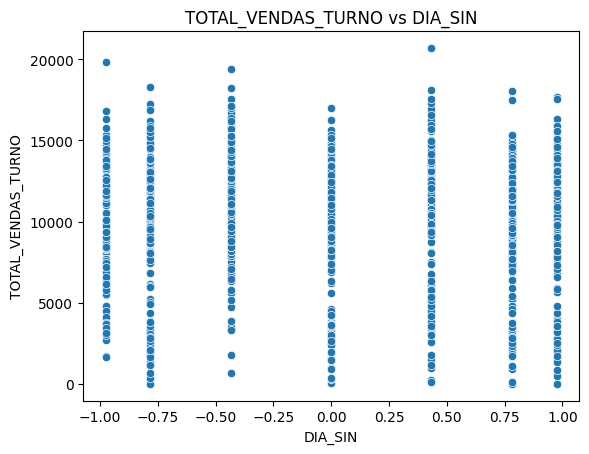

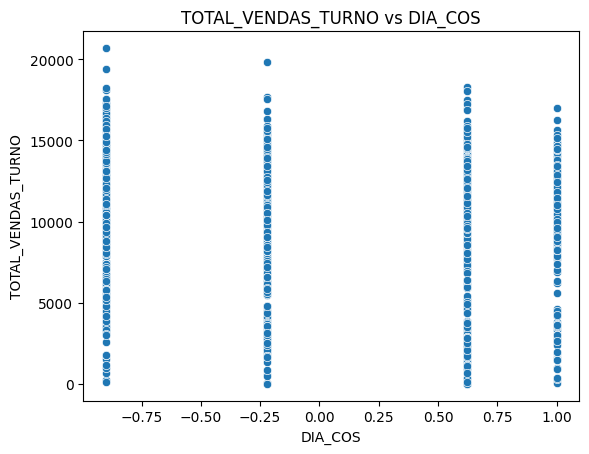

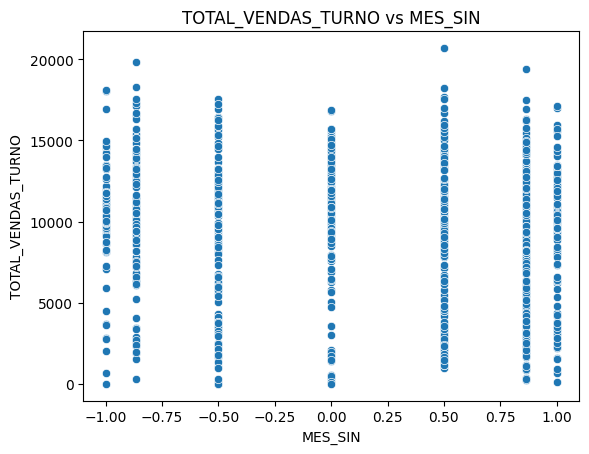

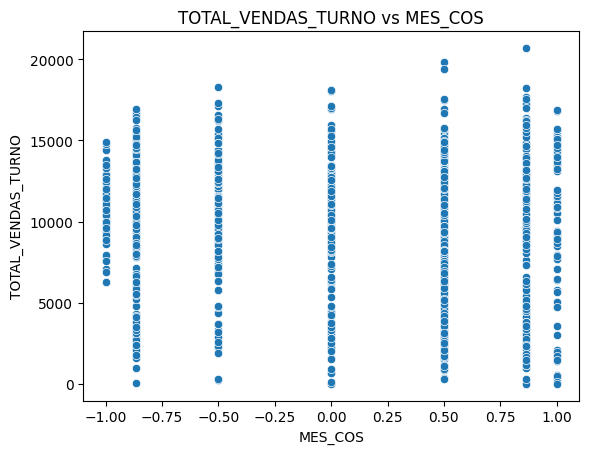

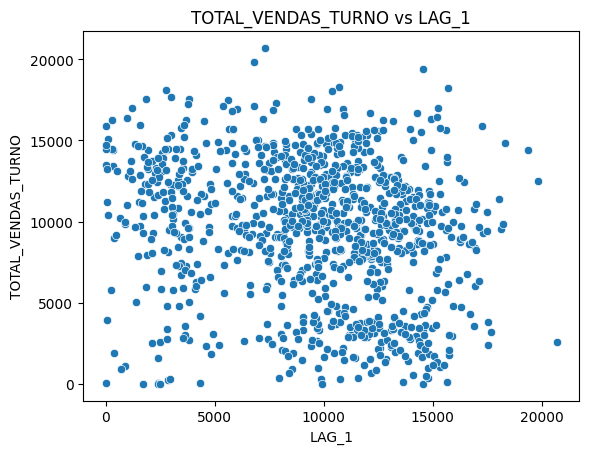

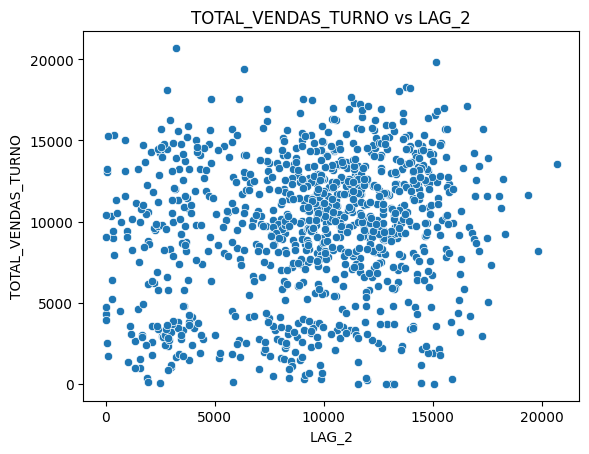

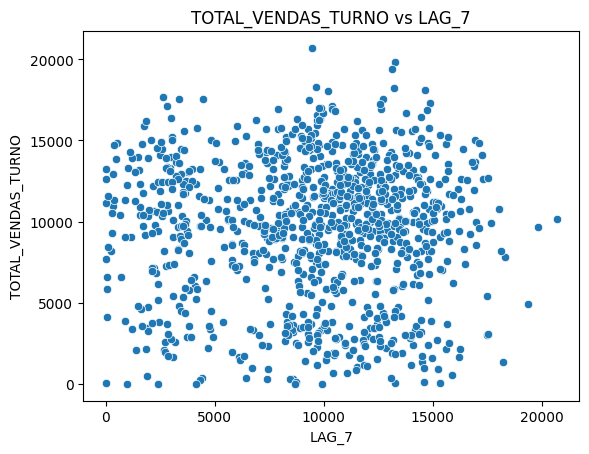

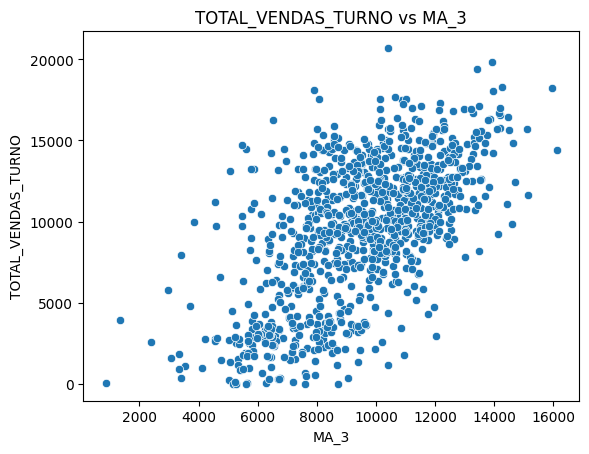

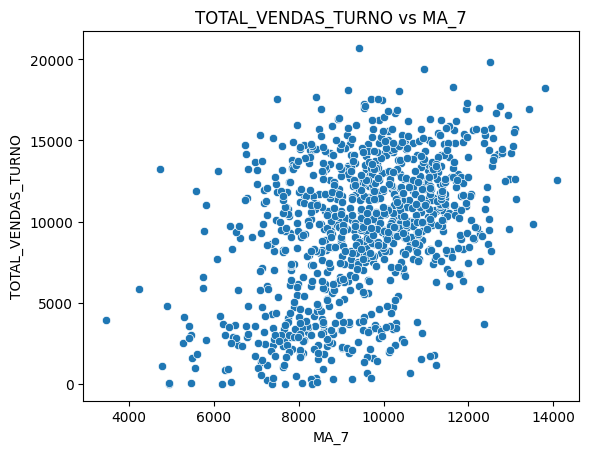

In [ ]:
outros_atrib = df.columns
target_attribute = 'TOTAL_VENDAS_TURNO'

# Loop para criar cada gráfico de dispersão
for attribute in outros_atrib:
    # Crie o gráfico de dispersão com seaborn
    sns.scatterplot(x=attribute, y=df[target_attribute], data=df)

    # Personalize o gráfico (opcional)
    plt.title(f'{target_attribute} vs {attribute}')
    plt.xlabel(attribute)
    plt.ylabel(target_attribute)

    # Exiba o gráfico
    plt.show()

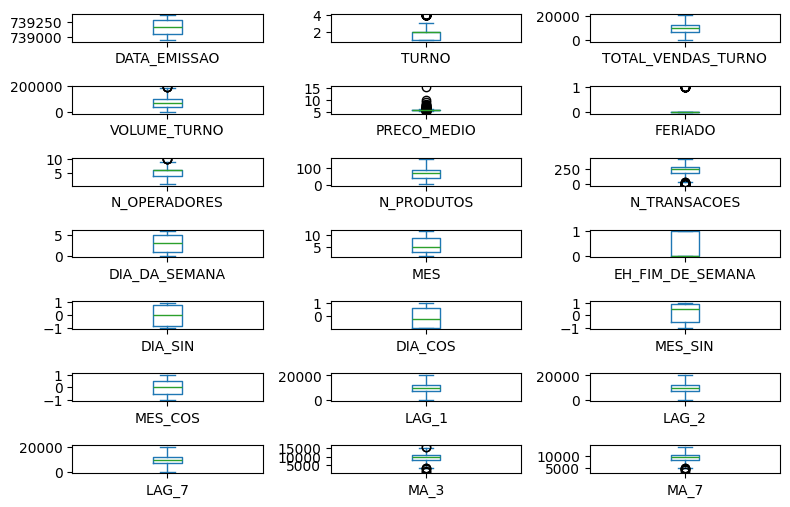

In [ ]:
df[df.columns].plot(kind='box',
                        layout=(df.shape[1],3),
                        subplots=True,
                        figsize=(8,15),
                        sharex=False)
plt.tight_layout()
plt.show()

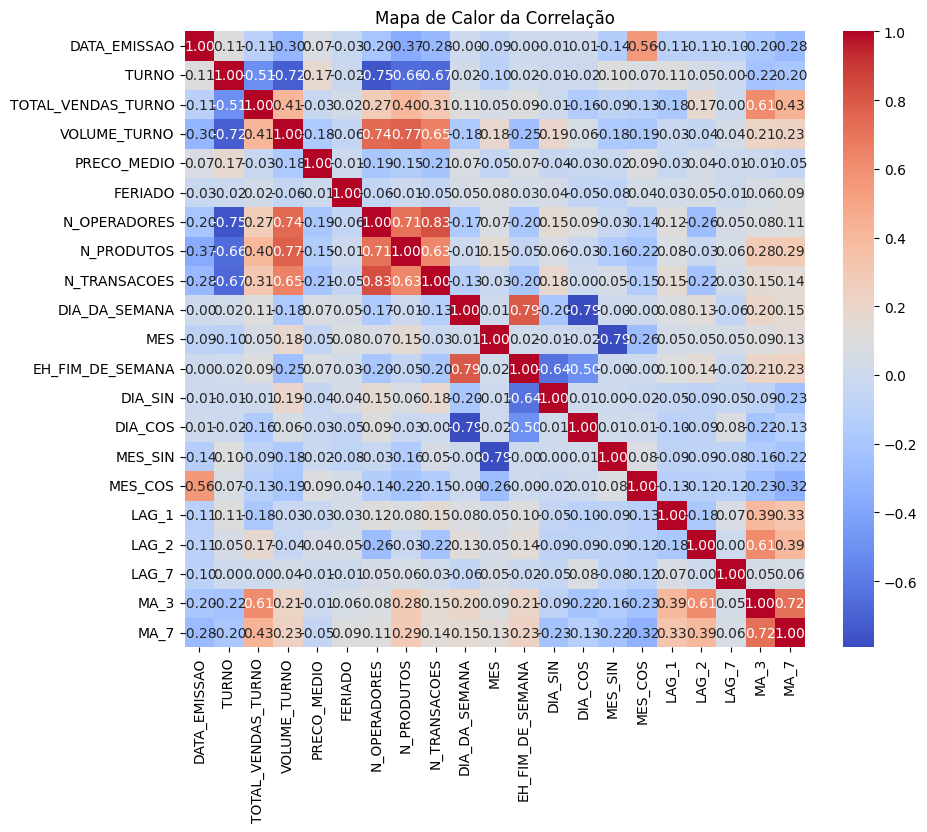

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de Calor da Correlação")
plt.show()

In [ ]:
df.corr()["TOTAL_VENDAS_TURNO"].sort_values(ascending=False)

,TOTAL_VENDAS_TURNO
TOTAL_VENDAS_TURNO,1.000000
MA_3,0.610963
MA_7,0.428355
VOLUME_TURNO,0.413313
N_PRODUTOS,0.401296
N_TRANSACOES,0.312619
N_OPERADORES,0.274169
LAG_2,0.170162
DIA_DA_SEMANA,0.110296
EH_FIM_DE_SEMANA,0.092733


In [ ]:
df.describe()

,DATA_EMISSAO,TURNO,TOTAL_VENDAS_TURNO,VOLUME_TURNO,PRECO_MEDIO,FERIADO,N_OPERADORES,N_PRODUTOS,N_TRANSACOES,DIA_DA_SEMANA,MES,EH_FIM_DE_SEMANA,DIA_SIN,DIA_COS,MES_SIN,MES_COS,LAG_1,LAG_2,LAG_7,MA_3,MA_7
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1.001000e+03,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,739160.192807,1.812188,9526.777952,71868.095991,5.812625,0.022977,4.850150,67.609391,222.898102,3.031968,6.006993,0.292707,-0.004753,-0.006468,0.128938,5.933297e-02,9525.351968,9526.016933,9537.041728,9526.048951,9524.792806
std,120.816124,0.818957,4239.968948,43168.202132,0.412801,0.149905,1.984823,32.838488,86.923849,2.003242,3.414813,0.455233,0.706680,0.708194,0.716839,6.833565e-01,4240.176898,4239.323388,4240.712621,2280.598564,1631.328735
min,738948.000000,1.000000,0.000000,76.955000,4.876000,0.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.000000,-0.974928,-0.900969,-1.000000,-1.000000e+00,0.000000,0.000000,0.000000,857.320000,3446.881429
25%,739055.000000,1.000000,7021.930000,40485.970000,5.696366,0.000000,4.000000,41.000000,181.000000,1.000000,3.000000,0.000000,-0.781831,-0.900969,-0.500000,-5.000000e-01,7021.930000,7021.930000,7035.560000,8022.686667,8428.348571
50%,739162.000000,2.000000,9990.090000,71555.266000,5.752923,0.000000,6.000000,72.000000,245.000000,3.000000,5.000000,0.000000,0.000000,-0.222521,0.500000,6.123234e-17,9990.090000,9990.090000,10016.080000,9704.046667,9612.671429
75%,739271.000000,2.000000,12611.990000,100003.307000,5.841974,0.000000,6.000000,92.000000,281.000000,5.000000,9.000000,1.000000,0.781831,0.623490,0.866025,5.000000e-01,12611.990000,12611.990000,12611.990000,11160.370000,10698.110000
max,739357.000000,4.000000,20691.490000,191645.701000,15.252000,1.000000,10.000000,159.000000,414.000000,6.000000,12.000000,1.000000,0.974928,1.000000,1.000000,1.000000e+00,20691.490000,20691.490000,20691.490000,16112.056667,14078.258571


#### 4.4.2. Remoção de Outliers

In [ ]:
numeric_cols = ['TOTAL_VENDAS_TURNO', 'VOLUME_TURNO', 'PRECO_MEDIO',
                'N_OPERADORES', 'N_PRODUTOS', 'N_TRANSACOES',]
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
low = Q1 - 1.5 * IQR
up = Q3 + 1.5 * IQR
df_shape_old = df.shape

mask = ((df[numeric_cols] >= low) & (df[numeric_cols] <= up))
df = df[mask.all(axis=1)]

print(f"Conjunto Com Outliers: {df_shape_old}")
print(f"Conjunto Sem Outliers: {df.shape}")

Conjunto Com Outliers: (1001, 21)
Conjunto Sem Outliers: (927, 21)


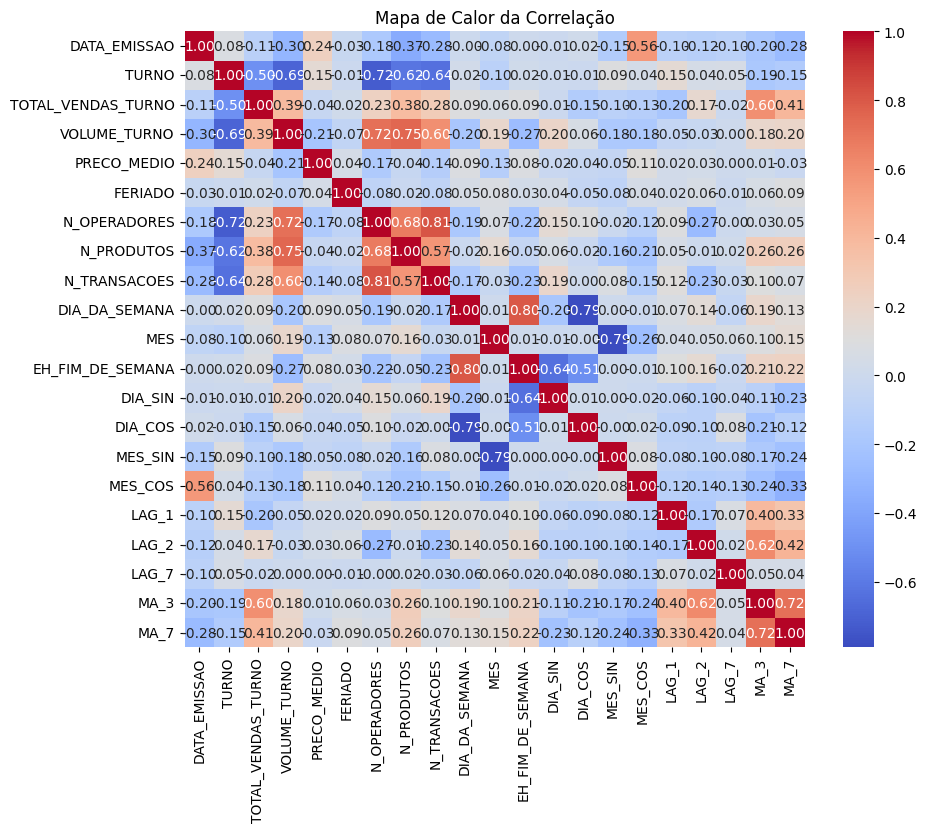

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de Calor da Correlação")
plt.show()

### 4.5. Redução de Dimensionalidade

Aparentemente o atributo `FERIADO` é irrelevante para o nosso problema, sendo assim vamos removê-la.

In [ ]:
#df.pop(columns=['FERIADO'])

# na vdd era pq removi outliers de atributos categoricos
# mas ja resolvi, da pra usar essa coluna... talvez

### 4.6. Divisão conjuntos de treinamento e teste

Como queremos sempre prever o futuro com base no passado, **desabilitei** o `shuffle` na criação dos conjuntos de treinamento e teste

In [ ]:
# separate data into train and test
'''
X = df.drop(columns=['TOTAL_VENDAS_TURNO'], axis=1)
y = df['TOTAL_VENDAS_TURNO']

x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=False,
                                                    )
'''

"\nX = df.drop(columns=['TOTAL_VENDAS_TURNO'], axis=1)\ny = df['TOTAL_VENDAS_TURNO']\n\nx_train, x_test, y_train, y_test = train_test_split(X, y,\n                                                    test_size=0.2,\n                                                    shuffle=False,\n                                                    )\n"

In [ ]:
feature_cols = [
    'VOLUME_TURNO','PRECO_MEDIO','N_OPERADORES','N_PRODUTOS','N_TRANSACOES',
    'DIA_SIN','DIA_COS','MES_SIN','MES_COS',
    'LAG_1','LAG_2','LAG_7','MA_3','MA_7'
]
cat_cols = ['TURNO','FERIADO','EH_FIM_DE_SEMANA']

X = df[feature_cols + cat_cols]
y = df['TOTAL_VENDAS_TURNO']

split = int(0.8 * len(df))
x_train, x_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

In [ ]:
print("X train: {}".format(x_train.shape))
print("y train: {}".format(y_train.shape))
print("X test: {}".format(x_test.shape))
print("y test: {}".format(y_test.shape))

X train: (741, 17)
y train: (741,)
X test: (186, 17)
y test: (186,)


### 4.7. Normalização dos Atributos

In [ ]:
x_train.describe()

,VOLUME_TURNO,PRECO_MEDIO,N_OPERADORES,N_PRODUTOS,N_TRANSACOES,DIA_SIN,DIA_COS,MES_SIN,MES_COS,LAG_1,LAG_2,LAG_7,MA_3,MA_7,TURNO,FERIADO,EH_FIM_DE_SEMANA
count,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,7.410000e+02,741.000000,741.000000,741.00000,741.000000,741.000000,741.000000,741.000000,741.000000
mean,80628.278370,5.758029,5.137652,75.654521,239.568151,-0.009571,-0.012898,-0.025606,-7.673880e-02,9830.004521,9723.602105,9818.23996,9817.344633,9806.625793,1.699055,0.031039,0.296896
std,40137.425845,0.104021,1.716360,29.977189,74.697153,0.714318,0.700601,0.709981,7.005175e-01,4125.163875,4093.573313,4054.03019,2205.417698,1505.310603,0.727723,0.173541,0.457199
min,6085.092000,5.486598,1.000000,5.000000,32.000000,-0.974928,-0.900969,-1.000000,-1.000000e+00,0.000000,0.000000,0.00000,857.320000,3446.881429,1.000000,0.000000,0.000000
25%,53418.814000,5.688899,5.000000,57.000000,208.000000,-0.781831,-0.900969,-0.866025,-8.660254e-01,7629.120000,7519.940000,7700.35000,8366.790000,8797.500000,1.000000,0.000000,0.000000
50%,80509.911000,5.741313,6.000000,80.000000,253.000000,0.000000,-0.222521,0.000000,-1.836970e-16,10367.070000,10129.770000,10307.29000,10018.893333,9818.401429,2.000000,0.000000,0.000000
75%,106412.635000,5.823928,6.000000,97.000000,287.000000,0.781831,0.623490,0.866025,5.000000e-01,12727.070000,12633.550000,12670.82000,11379.316667,10875.971429,2.000000,0.000000,1.000000
max,186340.986000,6.054499,9.000000,159.000000,414.000000,0.974928,1.000000,1.000000,1.000000e+00,19830.390000,19830.390000,19830.39000,15967.250000,14078.258571,4.000000,1.000000,1.000000


In [ ]:
scaler = StandardScaler()

numeric_cols = ['VOLUME_TURNO', 'PRECO_MEDIO',
                'N_OPERADORES', 'N_PRODUTOS', 'N_TRANSACOES',]

x_train[numeric_cols] = scaler.fit_transform(x_train[numeric_cols])

x_test[numeric_cols] = scaler.transform(x_test[numeric_cols])

<ipython-input-35-407e100213f3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[numeric_cols] = scaler.fit_transform(x_train[numeric_cols])
<ipython-input-35-407e100213f3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[numeric_cols] = scaler.transform(x_test[numeric_cols])


In [ ]:
x_train.describe()

,VOLUME_TURNO,PRECO_MEDIO,N_OPERADORES,N_PRODUTOS,N_TRANSACOES,DIA_SIN,DIA_COS,MES_SIN,MES_COS,LAG_1,LAG_2,LAG_7,MA_3,MA_7,TURNO,FERIADO,EH_FIM_DE_SEMANA
count,7.410000e+02,7.410000e+02,7.410000e+02,7.410000e+02,7.410000e+02,741.000000,741.000000,741.000000,7.410000e+02,741.000000,741.000000,741.00000,741.000000,741.000000,741.000000,741.000000,741.000000
mean,1.630125e-16,-1.116156e-14,1.198621e-16,1.246566e-16,-1.917794e-17,-0.009571,-0.012898,-0.025606,-7.673880e-02,9830.004521,9723.602105,9818.23996,9817.344633,9806.625793,1.699055,0.031039,0.296896
std,1.000675e+00,1.000675e+00,1.000675e+00,1.000675e+00,1.000675e+00,0.714318,0.700601,0.709981,7.005175e-01,4125.163875,4093.573313,4054.03019,2205.417698,1505.310603,0.727723,0.173541,0.457199
min,-1.858453e+00,-2.611140e+00,-2.412342e+00,-2.358535e+00,-2.780673e+00,-0.974928,-0.900969,-1.000000,-1.000000e+00,0.000000,0.000000,0.00000,857.320000,3446.881429,1.000000,0.000000,0.000000
25%,-6.783654e-01,-6.650238e-01,-8.025403e-02,-6.227109e-01,-4.229006e-01,-0.781831,-0.900969,-0.866025,-8.660254e-01,7629.120000,7519.940000,7700.35000,8366.790000,8797.500000,1.000000,0.000000,0.000000
50%,-2.951044e-03,-1.607986e-01,5.027679e-01,1.450574e-01,1.799389e-01,0.000000,-0.222521,0.000000,-1.836970e-16,10367.070000,10129.770000,10307.29000,10018.893333,9818.401429,2.000000,0.000000,0.000000
75%,6.428358e-01,6.339435e-01,5.027679e-01,7.125384e-01,6.354176e-01,0.781831,0.623490,0.866025,5.000000e-01,12727.070000,12633.550000,12670.82000,11379.316667,10875.971429,2.000000,0.000000,1.000000
max,2.635548e+00,2.852015e+00,2.251834e+00,2.782175e+00,2.336765e+00,0.974928,1.000000,1.000000,1.000000e+00,19830.390000,19830.390000,19830.39000,15967.250000,14078.258571,4.000000,1.000000,1.000000


In [ ]:
x_test.describe()

,VOLUME_TURNO,PRECO_MEDIO,N_OPERADORES,N_PRODUTOS,N_TRANSACOES,DIA_SIN,DIA_COS,MES_SIN,MES_COS,LAG_1,LAG_2,LAG_7,MA_3,MA_7,TURNO,FERIADO,EH_FIM_DE_SEMANA
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,1.860000e+02,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.0,186.000000
mean,-0.821702,0.307110,-0.440725,-1.027952,-0.597919,-0.009856,0.012908,0.770668,5.225461e-01,8809.352204,8407.114516,8845.354462,8620.679158,8664.663118,1.989247,0.0,0.301075
std,0.849889,1.026602,1.255500,0.869979,1.122125,0.707274,0.710566,0.198361,3.072271e-01,4634.033659,4599.111811,4660.313357,2290.345815,1723.505468,0.924088,0.0,0.459963
min,-1.956888,-2.251884,-2.412342,-2.391916,-2.753880,-0.974928,-0.900969,0.500000,6.123234e-17,689.500000,110.000000,110.000000,3339.166667,4766.138571,1.000000,0.0,0.000000
25%,-1.674413,-0.381768,-1.829320,-1.791054,-1.785988,-0.781831,-0.900969,0.500000,5.000000e-01,4274.060000,3838.087500,4223.090000,7162.375833,7485.530357,1.000000,0.0,0.000000
50%,-0.944041,0.231273,-0.080254,-1.056667,-0.228652,0.000000,-0.222521,0.866025,5.000000e-01,9334.665000,8736.010000,9305.780000,8495.995000,8423.222143,2.000000,0.0,0.000000
75%,-0.261643,0.976249,0.502768,-0.364006,0.220128,0.781831,0.623490,0.866025,8.660254e-01,12297.552500,11902.827500,12519.095000,10139.268333,9875.359286,3.000000,0.0,1.000000
max,1.825251,2.749376,2.251834,1.213257,1.975061,0.974928,1.000000,1.000000,8.660254e-01,20691.490000,19395.030000,19395.030000,16112.056667,13067.944286,4.000000,0.0,1.000000


## 5.0. Train Model

In [ ]:
modelos = []

### 5.2 Estratégia de Validação Cruzada

| KFold| TimeSeriesSplit|
|:-:|:-:|
|![KFold](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_006.png)|![TimeSeriesSplit](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png)|


Como `TimeSeriesSplit` respeita a ordem cronologica e queremos prever o futuro baseado no passado, então é a escolha mais lógica.

In [ ]:
# 5 folds temporais
tscv = TimeSeriesSplit(n_splits=5)

### 5.1. Modelo: `GradientBoostingRegressor`

In [ ]:
gbrmodel = GradientBoostingRegressor(loss='squared_error')

#### 5.1.1. GBR: Ajuste da Busca de Hiperparâmetros

RandomizedSearchCV busca a melhor combinação de hiperparâmetros para o modelo baseado em listas de hiperparametros definidas em `param_grid`

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200, 400, 1000],
    'max_features': [None, 'sqrt', 'log2'],
    'learning_rate': [0.01, 0.1, 0.3, 0.5, 0.75, 1],
    'subsample': [0.5, 0.75, 1],
    'max_depth': [3, 5, 7, 9, 10],
}

grid = RandomizedSearchCV(
    gbrmodel,
    param_distributions=param_grid,
    n_iter=100,                # Número de combinações testadas
    cv=tscv,                  # Usa TimeSeriesSplit em vez de KFold
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    #refit=True,
)

#### 5.1.3. GBR: Busca do Melhor Modelo

In [ ]:
%time best_model = grid.fit(x_train, y_train)

CPU times: user 3.88 s, sys: 634 ms, total: 4.51 s
Wall time: 3min 30s


In [ ]:
gbr_best_model = best_model
print("GBR Melhores hiperparâmetros:", gbr_best_model.best_params_)

GBR Melhores hiperparâmetros: {'subsample': 0.5, 'n_estimators': 200, 'max_features': None, 'max_depth': 5, 'learning_rate': 0.1}


#### 5.1.4. GBR: Guardar as Métricas do Melhor Modelo

In [ ]:
train_predictions = gbr_best_model.predict(x_train)
test_predictions = gbr_best_model.predict(x_test)

# R^2 expressa a quantidade da variância dos dados que é explicada pelo modelo linear.
r2 = r2_score(y_test, test_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

print("Train (RMSE):\t{}".format(train_rmse))
print("Test (RMSE):\t{}".format(test_rmse))
print("Train (MAE):\t{}".format(train_mae))
print("Test (MAE):\t{}".format(test_mae))
print("R²:\t\t{}".format(r2))

modelos.append({
    'name': 'GradientBoostingRegressor',
    'best_model': gbr_best_model,
    'best_params': gbr_best_model.best_params_,
    'train_predictions': train_predictions,
    'test_predictions': test_predictions,
    'R^2': r2,
    'train_rmse': train_rmse,
    'test_rmse': test_rmse,
    'train_mae': train_mae,
    'test_mae': test_mae
})

Train (RMSE):	102.04189098086607
Test (RMSE):	1341.3919090300592
Train (MAE):	84.57307990258685
Test (MAE):	987.1529906189876
R²:		0.9162844421203258


### 5.2. Modelo: `HistGradientBoostingRegressor`

In [ ]:
hgbmodel = HistGradientBoostingRegressor(
    loss='squared_error',
    early_stopping=True,              # <-- aqui!
    validation_fraction=0.1,          # % dos dados de treino reservados para validação interna
    n_iter_no_change=10,              # Para parar se não melhorar após 10 iterações
    scoring='loss',                   # Critério de parada (padrão é 'loss')
)

#### 5.2.1. HBR: Ajuste da Busca de Hiperparâmetros

In [ ]:
from scipy.stats import uniform, randint

param_grid = {
    'learning_rate': uniform(0.01, 0.99),  # Entre 0.01 e 1
    'max_iter': randint(50, 500),  # Inteiros entre 50 e 500
    'max_leaf_nodes': randint(10, 100),
    'max_depth': randint(3, 15),
    'l2_regularization': uniform(0.0, 0.1)  # Entre 0 e 0.1
}

grid = RandomizedSearchCV(
    hgbmodel,
    param_distributions=param_grid,    # Intervalos dos parâmetros
    n_iter=500,                                  # Número de combinações de parâmetros a serem testadas
    cv=tscv,
    scoring='neg_mean_squared_error',           # Métrica de avaliação (negativo pois queremos minimizar o erro)
    n_jobs=-1,                                  # Usar todos os núcleos do processador
    #refit=True,
)

#### 5.2.2. HBR: Busca do Melhor Modelo

In [ ]:
# fit grid search
%time best_model = grid.fit(x_train,y_train)

CPU times: user 5.71 s, sys: 548 ms, total: 6.26 s
Wall time: 2min 57s


In [ ]:
hbr_best_model = best_model
print("HBR Melhores hiperparâmetros:", hbr_best_model.best_params_)

HBR Melhores hiperparâmetros: {'l2_regularization': np.float64(0.09914963287006313), 'learning_rate': np.float64(0.16357054702993315), 'max_depth': 7, 'max_iter': 98, 'max_leaf_nodes': 84}


#### 5.2.3. HBR: Guardar as Métricas do Melhor Modelo

In [ ]:
train_predictions = hbr_best_model.predict(x_train)
test_predictions = hbr_best_model.predict(x_test)

# R^2 expressa a quantidade da variância dos dados que é explicada pelo modelo linear.

r2 = r2_score(y_test, test_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

print("Train (RMSE):\t{}".format(train_rmse))
print("Test (RMSE):\t{}".format(test_rmse))
print("Train (MAE):\t{}".format(train_mae))
print("Test (MAE):\t{}".format(test_mae))
print("R²:\t\t{}".format(r2))

modelos.append({
    'name': 'HistGradientBoostingRegressor',
    'best_model': hbr_best_model,
    'best_params': hbr_best_model.best_params_,
    'train_predictions': train_predictions,
    'test_predictions': test_predictions,
    'R^2': r2,
    'train_rmse': train_rmse,
    'test_rmse': test_rmse,
    'train_mae': train_mae,
    'test_mae': test_mae
})

Train (RMSE):	516.1167982001293
Test (RMSE):	1429.0905003191
Train (MAE):	294.2531503184662
Test (MAE):	1049.1852748604542
R²:		0.9049801642290601


### 5.3. Modelo: `RandomForestRegressor`

In [ ]:
rfmodel = RandomForestRegressor()

#### 5.3.1. RFR: Ajuste da Busca de Hiperparâmetros

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = RandomizedSearchCV(
    rfmodel,
    param_distributions=param_grid,
    scoring='neg_root_mean_squared_error',
    n_iter=100,
    cv=tscv,
    n_jobs=-1,
    #verbose=2
)

#### 5.3.2. RFR: Busca Melhor Modelo

In [ ]:
# fit grid search
%time best_model = grid.fit(x_train,y_train)

CPU times: user 5.81 s, sys: 703 ms, total: 6.52 s
Wall time: 6min


In [ ]:
rfr_best_model = best_model
print("HBR Melhores hiperparâmetros:", rfr_best_model.best_params_)

HBR Melhores hiperparâmetros: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}


#### 5.3.3. RFR: Guardar as Métricas do Melhor Modelo

In [ ]:
train_predictions = rfr_best_model.predict(x_train)
test_predictions = rfr_best_model.predict(x_test)

# R^2 expressa a quantidade da variância dos dados que é explicada pelo modelo linear.

r2 = r2_score(y_test, test_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

print("Train (RMSE):\t{}".format(train_rmse))
print("Test (RMSE):\t{}".format(test_rmse))
print("Train (MAE):\t{}".format(train_mae))
print("Test (MAE):\t{}".format(test_mae))
print("R²:\t\t{}".format(r2))

modelos.append({
    'name': 'RandomForestRegressor',
    'best_model': hbr_best_model,
    'best_params': rfr_best_model.best_params_,
    'train_predictions': train_predictions,
    'test_predictions': test_predictions,
    'R^2': r2,
    'train_rmse': train_rmse,
    'test_rmse': test_rmse,
    'train_mae': train_mae,
    'test_mae': test_mae
})

Train (RMSE):	703.7425654624913
Test (RMSE):	2006.9826720810213
Train (MAE):	510.45050506072806
Test (MAE):	1485.6959537634411
R²:		0.8125946190450513


## 6.0. Resultados

### 6.1. Hipeparâmetros Encontrados

In [ ]:
tabela_resultados = []

for modelo in modelos:
    nome = modelo['name']
    best_params = modelo.get('best_params', {})

    for param, valor in best_params.items():
        tabela_resultados.append({
            'Modelo': nome,
            'Hiperparâmetro': param,
            'Valor': valor
        })

df_resultados = pd.DataFrame(tabela_resultados)

pd.set_option('display.max_rows', None)
display(df_resultados)

,Modelo,Hiperparâmetro,Valor
0,GradientBoostingRegressor,subsample,0.500000
1,GradientBoostingRegressor,n_estimators,200.000000
2,GradientBoostingRegressor,max_features,NaN
3,GradientBoostingRegressor,max_depth,5.000000
4,GradientBoostingRegressor,learning_rate,0.100000
5,HistGradientBoostingRegressor,l2_regularization,0.099150
6,HistGradientBoostingRegressor,learning_rate,0.163571
7,HistGradientBoostingRegressor,max_depth,7.000000
8,HistGradientBoostingRegressor,max_iter,98.000000
9,HistGradientBoostingRegressor,max_leaf_nodes,84.000000


### 6.2. Gráfico de Função de Perda dos Modelos

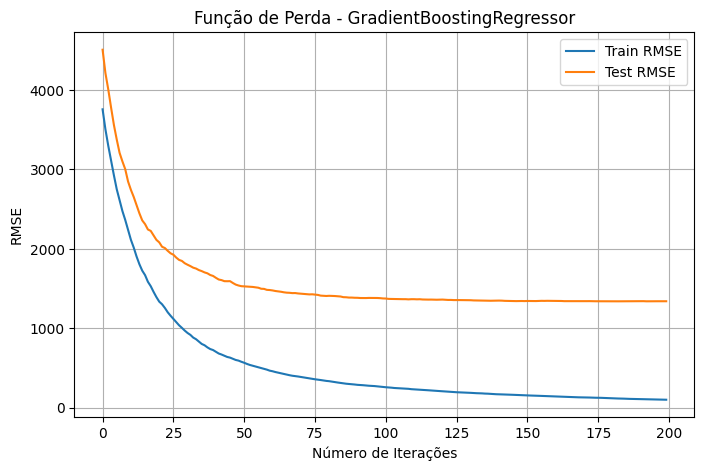

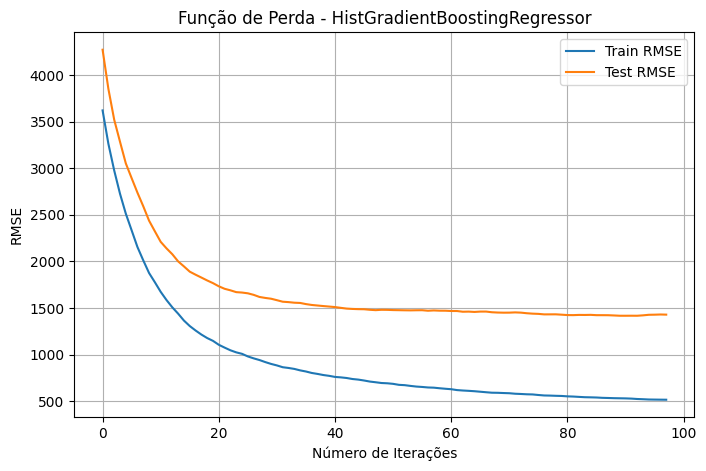

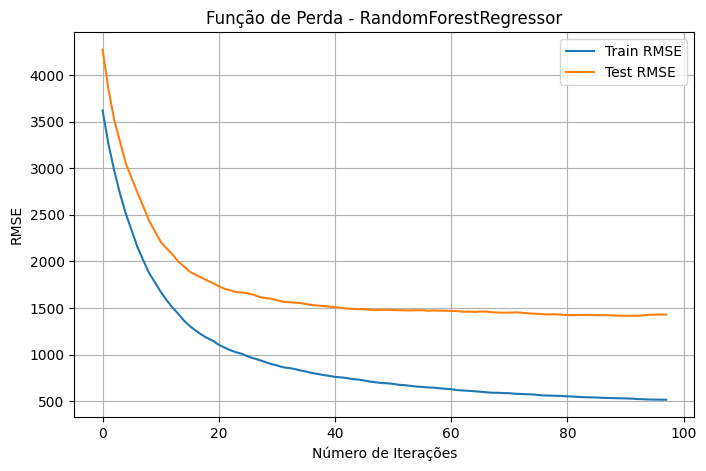

In [ ]:
for result in modelos:
    model_cv = result['best_model']
    model = model_cv.best_estimator_
    model_name = result['name']

    train_errors = []
    test_errors = []

    # Usamos staged_predict do modelo real
    for train_pred, test_pred in zip(model.staged_predict(x_train), model.staged_predict(x_test)):
        train_mse = mean_squared_error(y_train, train_pred)
        test_mse = mean_squared_error(y_test, test_pred)

        train_rmse = np.sqrt(train_mse)
        test_rmse = np.sqrt(test_mse)

        train_errors.append(train_rmse)
        test_errors.append(test_rmse)

    plt.figure(figsize=(8, 5))
    plt.plot(train_errors, label="Train RMSE")
    plt.plot(test_errors, label="Test RMSE")
    plt.title(f'Função de Perda - {model_name}')
    plt.xlabel('Número de Iterações')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.show()

### 6.3. Comparação das Metricas dos Modelos

In [ ]:
tabela_resultados = []

for result in modelos:
    tabela_resultados.append({
        'Modelo': result['name'],
        'R^2': result['R^2'],
        'Train RMSE': result['train_rmse'],
        'Test RMSE': result['test_rmse'],
        'Train MAE': result['train_mae'],
        'Test MAE': result['test_mae']
    })

metricas = pd.DataFrame(tabela_resultados)
metricas

,Modelo,R^2,Train RMSE,Test RMSE,Train MAE,Test MAE
0,GradientBoostingRegressor,0.916284,102.041891,1341.391909,84.573080,987.152991
1,HistGradientBoostingRegressor,0.904980,516.116798,1429.090500,294.253150,1049.185275
2,RandomForestRegressor,0.812595,703.742565,2006.982672,510.450505,1485.695954


### 6.4. Comparação: Dados Observados X Modelo

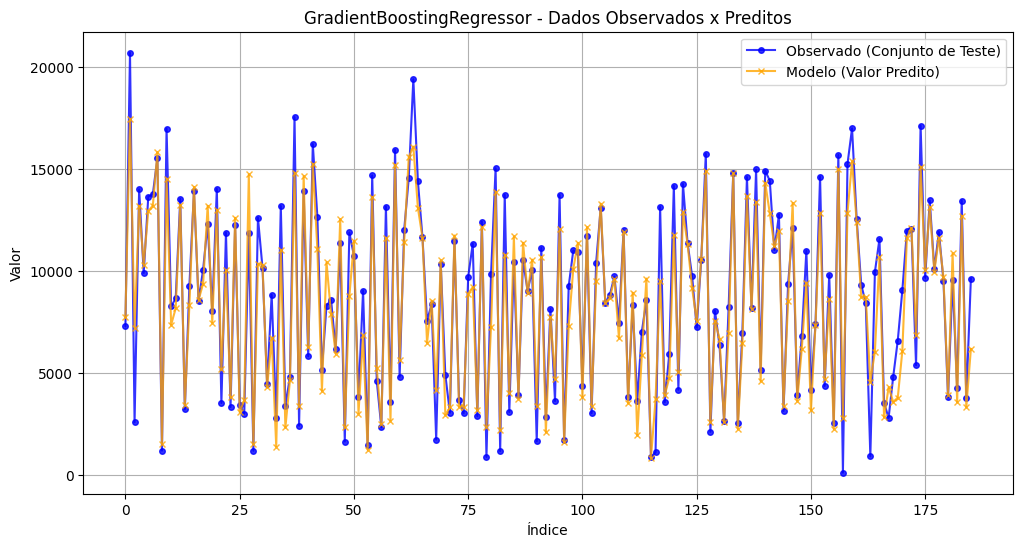

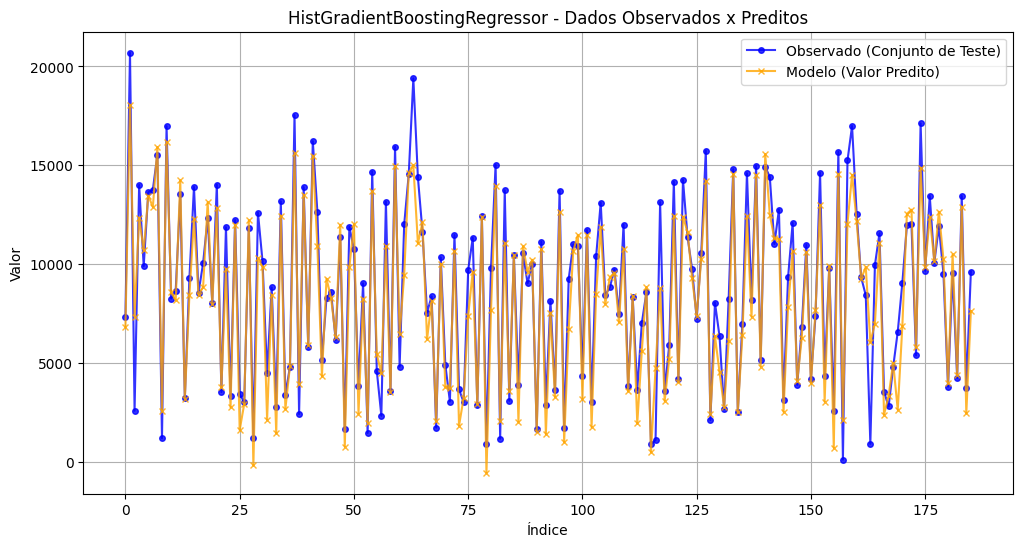

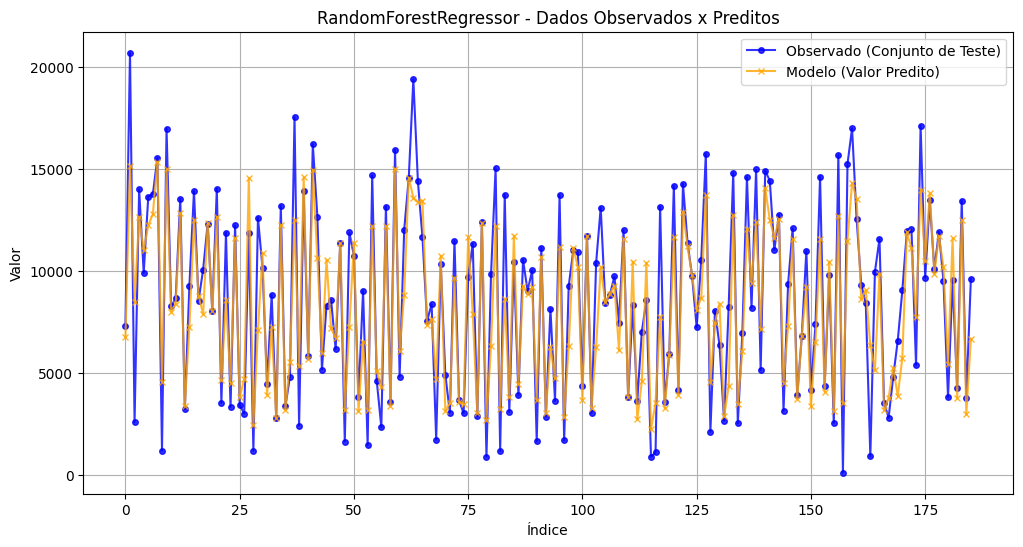

In [ ]:
for modelo in modelos:
    y_test = np.array(y_test)
    test_predictions = np.array(modelo['test_predictions'])

    indices = np.arange(len(y_test))

    plt.figure(figsize=(12, 6))
    plt.plot(indices, y_test, label='Observado (Conjunto de Teste)', color='blue', alpha=0.8, marker='o', markersize=4)
    plt.plot(indices, test_predictions, label='Modelo (Valor Predito)', color='orange', alpha=0.8, marker='x', markersize=4)
    plt.xlabel('Índice')
    plt.ylabel('Valor')
    plt.title(f"{modelo['name']} - Dados Observados x Preditos")
    plt.legend()
    plt.grid(True)
    plt.show()


## 7.0. Referências

- Time-related feature engineering:

 https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py

- Visualizing cross-validation behavior in scikit-learn:

 https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py

- TimeSeriesSplit:

 https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

- Lagged features for time series forecasting:

 https://scikit-learn.org/stable/auto_examples/applications/plot_time_series_lagged_features.html#sphx-glr-auto-examples-applications-plot-time-series-lagged-features-py